In [9]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
from datasets import load_dataset
from torchvision import transforms
from torch.nn import functional as F
import PIL
from PIL import Image
def show_images(x):

    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

image_size = 32
batch_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


def transform(examples):
    images = [
        preprocess(image.convert("RGB")) for image in examples["image"]
        ]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

X shape:  torch.Size([8, 3, 32, 32])


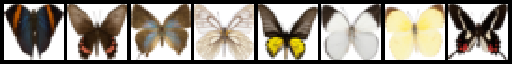

In [11]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape: ", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.Resampling.NEAREST)

In [14]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# here are some other options:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, 
#                                 beta_start=0.001, 
#                                 beta_end=0.004,
#                                 beta_schedule='squaredcos_cap_v2')


Noisy X shape:  torch.Size([8, 3, 32, 32])


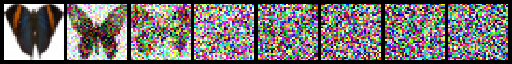

In [16]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape: ", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.Resampling.NEAREST)

In [ ]:
from diffusers import UNet2DModel

# 创建模型
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)

# 测试模型
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
print("Model prediction shape: ", model_prediction.shape)

In [ ]:
# 设定噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
)

# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # 为图片添加采样噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # 为每张图片随机采样一个时间步
        noise = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,),
            device=clean_images.device
        ).long()

        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(
            clean_images,
            noise,
            timesteps
        )

        # 获得模型的预测结果
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)